In [37]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

MYPROJECT='/Users/erotundo/PycharmProjects/DatasetAnnotatorProj'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")

import itertools

import django
django.setup()

from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q, F
from django.db.models import Count, Sum, Max, Avg
from django.db.models import When, Case, Value
from django.db.models import IntegerField, FloatField
import numpy as np
import pandas as pd
from django.db.models.functions import Greatest, Coalesce
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# community selection
db = 'travel'
available_dbs = [db] #settings.DATABASES.keys()[1:]

sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = MYPROJECT + '/AnalysisQuality/output/' + db + '/'
PLOTS_FORMATS = ['.pdf', '.png']

In [38]:
shared_questions = {
        'webapps': [],
        'travel': [44925L,
                1044L,
                13896L,
                10251L,
                52348L,
                47877L,
                67671L,
                4126L,
                24220L,
                1327L,
                10044L,
                31629L,
                1153L,
                9004L,
                45787L,
                36737L,
                10148L,
                40097L,
                60137L,
                269L,
                59883L,
                49372L,
                18938L,
                7140L,
                73450L,
                18647L,
                4365L,
                4573L,
                64099L,
                42216L,
                59986L,
                51842L,
                35928L,
                74805L,
                21285L,
                37364L,
                61522L,
                43272L,
                65267L,
                39294L,
                49889L,
                2062L,
                10461L,
                14683L,
                3759L,
                10776L,
                4772L,
                14049L,
                44652L,
                20389L,
                20741L,
                9519L,
                13497L,
                71964L,
                45588L,
                42621L,
                7794L,
                51768L,
                7492L,
                21335L,
                76998L,
                44964L,
                37726L,
                48349L,
                63782L,
                57303L,
                10578L,
                1454L,
                17272L,
                13533L,
                9589L,
                72446L,
                66398L,
                17238L,
                46237L,
                22469L,
                69316L,
                26362L,
                13385L,
                11451L,
                38050L,
                13241L,
                39835L,
                68165L,
                22687L,
                10078L,
                77776L,
                33981L,
                4277L,
                2116L,
                5113L,
                43994L,
                58613L,
                24225L,
                2966L,
                21486L,
                77658L,
                35428L,
                74638L,
                65226L],
        'cooking': []
    }

# Cohen's Kappa score, for each db

In [39]:
# keys: available_dbs
# values: pandas DataFrame with paired Cohens' kappa scores
kappas = {}

for db in available_dbs:
    os.write(1, '\n************************\n{}\n************************\n'.format(db))
    question_id_list = shared_questions[db]
    
    # get all shared questions
    questions = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .filter(id__in=question_id_list)
    
    # to be filled with a very long list of annotations
    data = {
        'enrico' : [],
        'marit' : [],
        'henrik': [],
        'christine': []
    }    
    
    # for each thread
    for question in questions:
        
        # fill with annotations in the format [question.annt + answers.annot]
        thread_data = {}
        
        answers = Posts.objects\
            .using(db)\
            .filter(parentid=question.id)\
            .filter(posttypeid=2)
        
        thread_data['enrico'] = [question.annotatedqualityenrico] + \
                         [answer.annotatedqualityenrico for answer in answers]
        
        thread_data['marit'] = [question.annotatedqualitymarit] + \
                         [answer.annotatedqualitymarit for answer in answers]
        
        thread_data['christine'] = [question.annotatedqualitychristine] + \
                         [answer.annotatedqualitychristine for answer in answers]
        
        thread_data['henrik'] = [question.annotatedqualityhenrik] + \
                         [answer.annotatedqualityhenrik for answer in answers]
        
        # consistency check: retrived same amout of annotations
        expected_len = len(thread_data['enrico'])
        if len(thread_data['marit']) != expected_len or \
            len(thread_data['christine']) != expected_len or \
                len(thread_data['henrik']) != expected_len:
            os.write(1, "WARN\n")
   
        
        # append to user's annotations
        data['enrico'] += thread_data['enrico']
        data['marit'] += thread_data['marit']
        data['christine'] += thread_data['christine']
        data['henrik'] += thread_data['henrik']
    
    
    # columns are users's annotations
    # NOTE: -1 means 'dont know', NaN means missing value (not even annotated)
    data_df = pd.DataFrame.from_dict(data)
    
    # check for NaNs
    #os.write(1, '{}\n'.format(data_df.isnull().count()))
    
    

    # tear down -1 (Don't know values --> NaN)
    data_df_filtered = data_df.replace(-1, np.NaN)
    
    # drop all NaNs rows
    data_df_filtered = data_df_filtered.dropna(axis='index')
    
    os.write(1, 'Filtered:\t{} over {}; Excluded ratio: {:.2f}%\n------------------\n'.format(data_df_filtered.size, 
                                                                        data_df.size, 
                                                                        (data_df.size - data_df_filtered.size) / float(data_df.size) * 100))
    
    for key in data.keys():
        os.write(1, '{}\n'.format(data_df[key].value_counts(dropna=False, sort=False)))

    
    # paired users' kappa scores
    kappa_df = pd.DataFrame(np.nan, index=data.keys(), columns=data.keys())
    
    
    for ann1, ann2 in itertools.permutations(data.keys(), 2):
        # fill the table
        kappa_df.loc[ann1,ann2] = cohen_kappa_score(data_df_filtered[ann1], data_df_filtered[ann2], labels=[0,1,2])
        
    kappas[db] = kappa_df

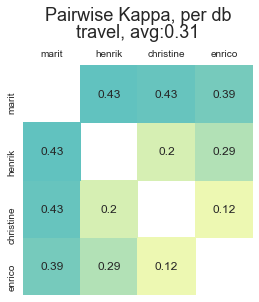

In [40]:
y_offset = 1.1

fig = plt.figure(figsize=(12, 5))
fig.suptitle("Pairwise Kappa, per db", fontsize=18)

"""
ax1 = fig.add_subplot(131)
sns.heatmap(kappas['cooking'], annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=ax1, square=True, cbar=False)
ax1.xaxis.tick_top()
plt.title('cooking, avg:{0:.2f}'.format(kappas['cooking'].mean().mean()), fontsize=18, y=y_offset)
"""

ax2 = fig.add_subplot(132)
sns.heatmap(kappas['travel'], annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=ax2, square=True, cbar=False)
ax2.xaxis.tick_top()
plt.title('travel, avg:{0:.2f}'.format(kappas['travel'].mean().mean()), fontsize=18, y=y_offset)

"""
ax3 = fig.add_subplot(133)
sns.heatmap(kappas['webapps'], annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=ax3, square=True, cbar=False)
ax3.xaxis.tick_top()
plt.title('webapps, avg:{0:.2f}'.format(kappas['webapps'].mean().mean()), fontsize=18, y=y_offset)
"""

plt.tight_layout(pad=3)

for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'kappa_stats' + plot_format)

# Annotations for each thread

In [42]:
k = {}

ts_ = {}

for db in available_dbs:
    question_id_list = shared_questions[db]
    
    questions = Posts.objects\
    .using(db)\
    .filter(posttypeid=1)\
    .filter(id__in=question_id_list)

    ts = {}

    data = {
        'enrico' : [],
        'marit' : [],
        'henrik': [],
        'christine': []
    }    
    for question in questions:
        
        thread_data = {}
        
        answers = Posts.objects\
            .using(db)\
            .filter(parentid=question.id)\
            .filter(posttypeid=2)
        
        thread_data['enrico'] = [question.annotatedqualityenrico] + \
                         [answer.annotatedqualityenrico for answer in answers]
        
        thread_data['marit'] = [question.annotatedqualitymarit] + \
                         [answer.annotatedqualitymarit for answer in answers]
        
        thread_data['christine'] = [question.annotatedqualitychristine] + \
                         [answer.annotatedqualitychristine for answer in answers]
        
        thread_data['henrik'] = [question.annotatedqualityhenrik] + \
                         [answer.annotatedqualityhenrik for answer in answers]
        
        ts[question.id] = thread_data
        

        
    ts_[db] = ts
    

for db_ in ts_.keys():
    db_kappas = [] #collects kappas for each thread in db_
    for thread_ in ts_[db_].keys():
        thread_kappas = [] #kappas for each item in thread_
        for ann1, ann2 in itertools.permutations(data.keys(), 2):
            try:
                score = None
                if ts_[db_][thread_][ann1] != ts_[db_][thread_][ann2]:
                    score = cohen_kappa_score(ts_[db_][thread_][ann1], ts_[db_][thread_][ann2], labels=[0,1,2])
                else:
                    score = 1.0
                if score is np.NaN:
                    print ts_[db_][thread_][ann1]
                    print ts_[db_][thread_][ann2]
                    print ""
                #print "{},{}".format(thread_, score)
            except:
                print thread_
                
            thread_kappas.append(score)
        db_kappas.append(np.mean(thread_kappas))
    #print db_kappas
    print np.mean(db_kappas)

0.507538314109
